In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from lime import lime_tabular
import shap
import warnings
warnings.filterwarnings("ignore")

# Задача прогнозирования табличных данных

<h3>Датасет</h3>

<p>Датасет состоит из двух файлов: БД_ИБК, содержащего месячные данные,
характеризующие бизнес-климат в России на протяжении последних 20 лет, и macro
data, содержащего ряд макропоказателей за тот же период. 
</p>
<p><b>Описание основных признаков:<b></p>
Бинарные переменные отраслей

| Код          | Отрасль экономики                          |
|--------------|--------------------------------------------|
| **Economy**  | Все отрасли                                |
| **Industry** | Промышленное производство                 |
| **Min_extract** | Добыча полезных ископаемых             |
| **Manufact_ind** | Обрабатывающие производства           |
| **Farming**  | Сельское и лесное хозяйство               |
| **Building** | Строительство                             |
| **Retail**   | Торговля и ремонт автотранспорта          |
| **Trans_Stor** | Транспортировка и хранение             |
| **Service**  | Услуги                                    |

Общие показатели для всех отраслей:

| Код             | Описание показателя                                                                 |
|-----------------|-----------------------------------------------------------------------------------|
| **Delta_Y**     | Изменение объема производства/работ/товарооборота/услуг                           |
| **Delta_Y_exp3**| Ожидаемое изменение объема (3 месяца)                                             |
| **Delta_D**     | Изменение спроса на продукцию/товары/услуги                                       |
| **Delta_D_exp3**| Ожидаемое изменение спроса (3 месяца)                                             |
| **Price_exp3**  | Ценовые ожидания на 3 месяца                                                      |
| **Ec_delta_price**| Изменение цен на продукцию/тарифов                                                |
| **Ec_delta_costs**| Изменение издержек производства                                                   |
| **Delta_credit** | Изменение условий кредитования                                                    |

# Целевые переменные - IBC (Индикатор бизнес-климата Банка России) для каждой отрасли

In [58]:
data = pd.read_excel('БД_ИБК.xlsx', sheet_name='Prepared_data')
data_macro = pd.read_excel('macro data.xlsx')

In [59]:
print(data.shape)
data.head(3)

(248, 136)


,Date,Economy_All,Economy_Big,Economy_Medium,Economy_Small,Economy_IBC,Economy_IBC_fact,Economy_IBC_exp,Economy_Delta_Y,Economy_Delta_Y_exp3,...,Service_IBC_fact,Service_IBC_exp,Service_Delta_Y,Service_Delta_Y_exp3,Service_Delta_D,Service_Delta_D_exp3,Service_Price_exp3,Service_Delta_price,Service_Delta_costs,Service_Delta_credit
0,2002-01-01,NaN,NaN,NaN,NaN,2.96,-19.04,27.63,-23.48,29.84,...,-5.25,33.90,-9.25,36.52,-1.17,31.32,38.53,44.34,55.53,-6.68
1,2002-02-01,NaN,NaN,NaN,NaN,10.68,-6.81,29.76,-6.80,32.21,...,6.23,35.85,5.24,38.67,7.22,33.07,35.36,28.13,45.77,-6.43
2,2002-03-01,NaN,NaN,NaN,NaN,18.36,8.24,28.96,14.88,31.03,...,20.30,36.10,25.17,38.47,15.54,33.75,29.76,24.27,46.17,-4.25


In [60]:
print(data_macro.shape)
data_macro.head(3)

(248, 15)


,Date,MOEX_end_of_month,MOEX_max,MOEX_min,Urals Crude Oil Price per 1 Barrel: Russia,CPI,CPI (SA),Labour Force Demand: Russia,Labour Force Demand: Russia (SA),Real wages,Real wages (SA),Freight Turnover: Russia,Freight Turnover: Russia (SA),Passenger Turnover: Russia,Passenger Turnover: Russia (SA)
0,2002-01-01,260.77,273.74,246.79,18.30,103.090000,102.688584,858234.0,986750.041791,72.782953,76.826695,318.4,317.7042,27.20000,32.00470
1,2002-02-01,262.65,269.87,250.71,18.80,104.285844,103.546544,828867.0,977504.905437,71.254511,77.250788,305.8,325.3058,25.21440,32.01901
2,2002-03-01,302.96,302.96,270.04,21.93,105.412131,104.603974,852776.0,973014.840454,76.313582,78.423198,336.9,326.3381,28.16448,32.10164


In [61]:
data.drop('Date', axis=1).describe()

,Economy_All,Economy_Big,Economy_Medium,Economy_Small,Economy_IBC,Economy_IBC_fact,Economy_IBC_exp,Economy_Delta_Y,Economy_Delta_Y_exp3,Economy_Delta_D,...,Service_IBC_fact,Service_IBC_exp,Service_Delta_Y,Service_Delta_Y_exp3,Service_Delta_D,Service_Delta_D_exp3,Service_Price_exp3,Service_Delta_price,Service_Delta_costs,Service_Delta_credit
count,44.000000,44.000000,44.000000,44.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,...,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,12517.113636,2659.590909,1910.613636,7946.909091,6.424395,-1.547540,14.894718,-0.484637,15.747218,-2.569556,...,0.099113,13.969355,0.990524,15.008145,-0.760081,12.937863,14.454073,10.626008,24.409032,-4.875766
std,1182.755872,155.573406,181.929863,943.518916,8.763544,10.409284,10.588099,11.995766,11.024406,9.295498,...,10.666957,10.241626,11.695956,10.615375,10.108412,9.903442,8.288527,6.755687,9.862140,8.378954
min,9565.000000,2114.000000,1527.000000,5689.000000,-22.010000,-40.830000,-20.400000,-43.660000,-19.550000,-38.820000,...,-46.180000,-28.640000,-45.060000,-27.930000,-47.280000,-29.340000,2.090000,-2.860000,9.510000,-47.130000
25%,11576.000000,2651.250000,1720.500000,7130.250000,0.800000,-6.825000,8.402500,-5.275000,8.767500,-8.140000,...,-6.152500,7.382500,-5.170000,8.147500,-7.330000,6.640000,8.007500,5.557500,16.190000,-6.532500
50%,12483.000000,2724.000000,1983.500000,7908.000000,6.060000,-0.275000,14.330000,1.425000,15.185000,-2.015000,...,-0.200000,13.505000,1.585000,14.335000,-0.400000,12.620000,12.485000,9.030000,21.740000,-2.105000
75%,13470.250000,2750.500000,2063.250000,8811.500000,12.930000,5.585000,23.255000,6.867500,24.305000,3.957500,...,7.485000,21.962500,9.017500,23.360000,7.527500,20.760000,18.620000,13.677500,30.940000,0.000000
max,14420.000000,2827.000000,2162.000000,9506.000000,23.290000,16.040000,32.830000,20.850000,33.920000,14.110000,...,21.460000,36.100000,27.840000,38.670000,16.960000,33.750000,39.010000,44.340000,57.130000,5.860000


In [62]:
data_macro.drop('Date', axis=1).describe()

,MOEX_end_of_month,MOEX_max,MOEX_min,Urals Crude Oil Price per 1 Barrel: Russia,CPI,CPI (SA),Labour Force Demand: Russia,Labour Force Demand: Russia (SA),Real wages,Real wages (SA),Freight Turnover: Russia,Freight Turnover: Russia (SA),Passenger Turnover: Russia,Passenger Turnover: Russia (SA)
count,248.000000,248.000000,248.000000,247.000000,247.000000,247.000000,2.470000e+02,2.470000e+02,247.000000,247.000000,248.000000,248.000000,248.000000,248.000000
mean,1640.796935,1715.437903,1546.564234,66.238785,300.182401,300.144701,1.354497e+06,1.354803e+06,161.615839,161.521704,416.833721,416.967631,37.108621,37.082942
std,851.043645,880.463460,824.078918,27.746030,130.542814,130.459058,3.669125e+05,3.364692e+05,42.510299,39.976399,41.462218,39.430205,8.808840,5.458804
min,260.770000,269.870000,246.790000,18.220000,103.090000,102.688584,7.243790e+05,8.805648e+05,71.254511,76.826695,305.800000,317.704200,6.750112,8.643953
25%,1227.185000,1365.492500,1068.077500,45.185000,179.474404,178.181386,1.046250e+06,1.014776e+06,136.997090,137.766632,391.507950,392.805050,31.149605,34.621702
50%,1539.865000,1612.005000,1467.950000,63.340000,281.877517,280.816027,1.352602e+06,1.330846e+06,168.875407,174.635786,415.832250,418.386450,35.758835,36.415355
75%,2067.530000,2108.962500,1973.652500,85.015000,423.301088,423.157137,1.628156e+06,1.614495e+06,190.799565,194.007531,447.537700,449.329750,42.859010,40.227937
max,4150.000000,4292.680000,4065.400000,129.710000,583.048032,578.615432,2.248109e+06,2.102577e+06,278.930392,219.191023,498.262600,488.333600,62.219610,48.382870


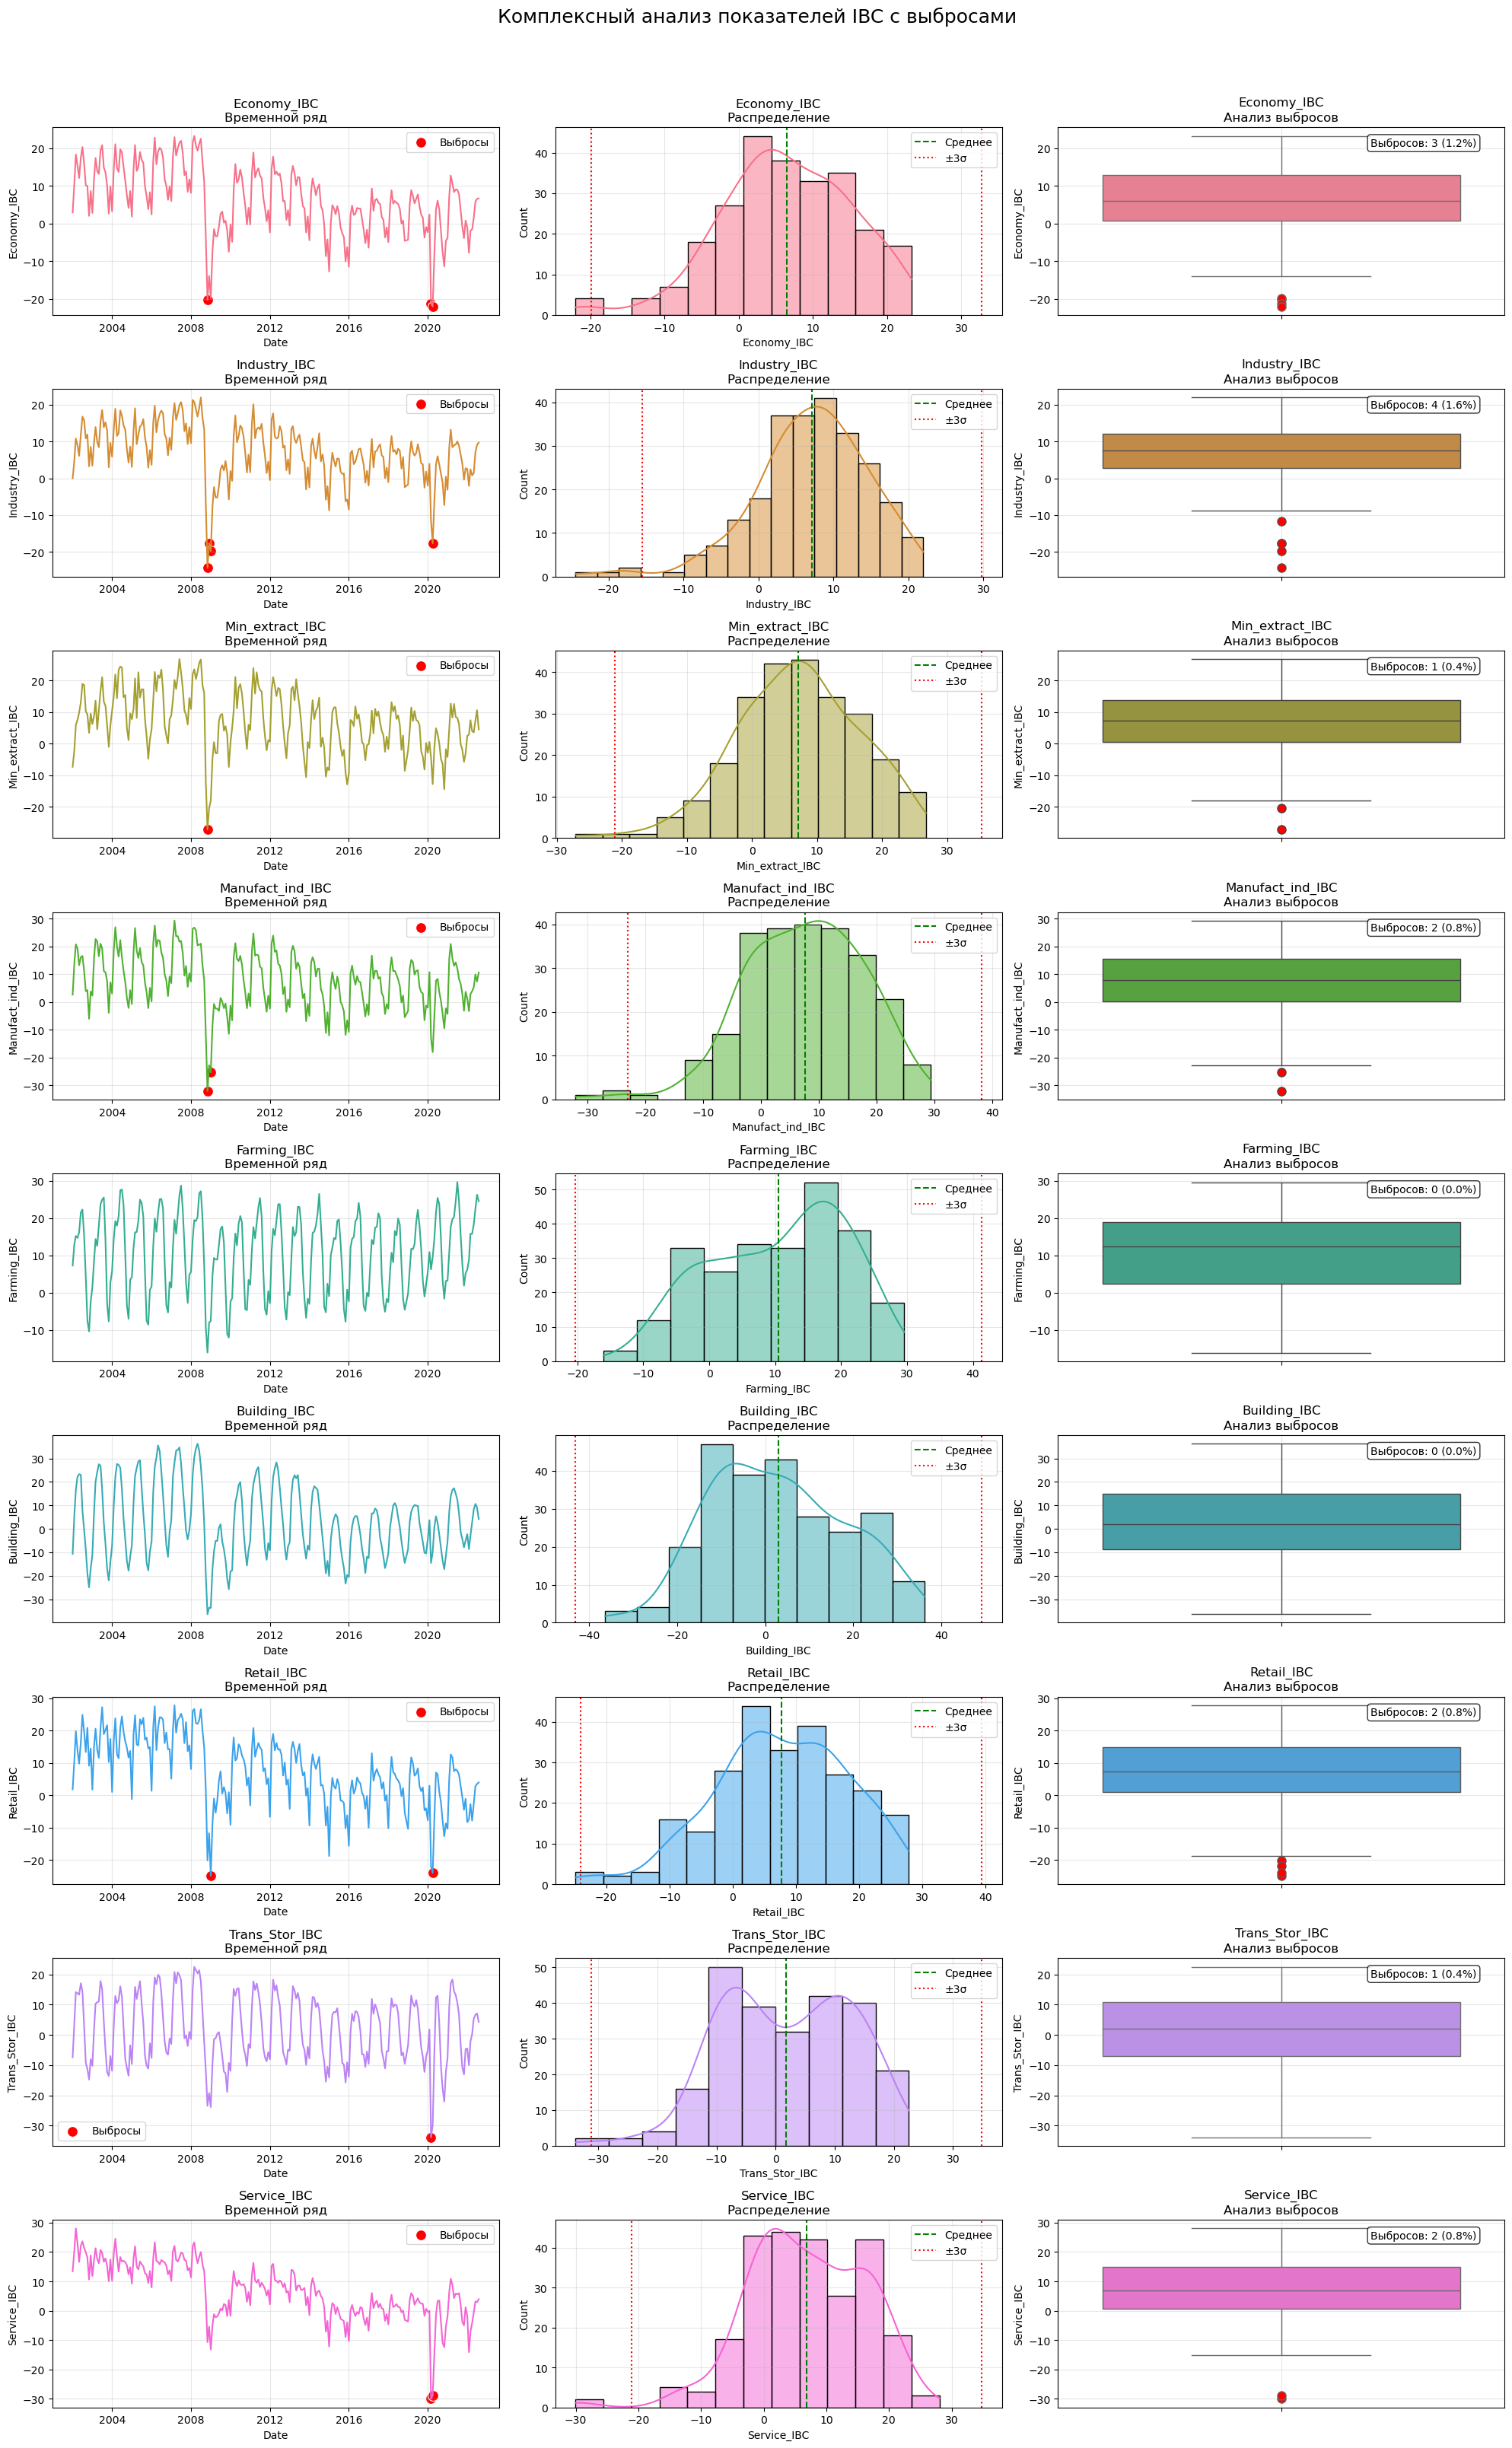

In [63]:
columns_to_plot = list(filter(lambda x: x.split('_')[-1] == 'IBC', 
                            (data.select_dtypes(include=['float64']).columns)))

n_cols = 3  
n_rows = len(columns_to_plot)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3.5*n_rows))
fig.suptitle('Комплексный анализ показателей IBC с выбросами', fontsize=18, y=1.02)

if len(columns_to_plot) == 1:
    axes = np.array([axes])
axes = axes.reshape(n_rows, n_cols)  

palette = sns.color_palette("husl", len(columns_to_plot))

for i, column in enumerate(columns_to_plot):
    sns.lineplot(data=data, x='Date', y=column, 
                color=palette[i], linewidth=1.5, ax=axes[i, 0])
    
    mean = data[column].mean()
    std = data[column].std()
    outliers = data[(data[column] < mean - 3*std) | (data[column] > mean + 3*std)]
    
    if not outliers.empty:
        sns.scatterplot(data=outliers, x='Date', y=column, 
                       color='red', s=100, label='Выбросы', ax=axes[i, 0])
        axes[i, 0].legend()
    
    axes[i, 0].set_title(f'{column}\nВременной ряд', fontsize=12)
    axes[i, 0].grid(True, alpha=0.3)
    
    sns.histplot(data=data, x=column, kde=True, 
                color=palette[i], ax=axes[i, 1])
    
    axes[i, 1].axvline(mean, color='green', linestyle='--', label='Среднее')
    axes[i, 1].axvline(mean - 3*std, color='red', linestyle=':', label='±3σ')
    axes[i, 1].axvline(mean + 3*std, color='red', linestyle=':')
    axes[i, 1].legend()
    
    axes[i, 1].set_title(f'{column}\nРаспределение', fontsize=12)
    axes[i, 1].grid(True, alpha=0.3)
    
    sns.boxplot(data=data, y=column, color=palette[i], ax=axes[i, 2], 
               flierprops=dict(markerfacecolor='red', markersize=8))
    axes[i, 2].set_title(f'{column}\nАнализ выбросов', fontsize=12)
    axes[i, 2].grid(True, alpha=0.3)
    
    n_outliers = len(outliers)
    axes[i, 2].annotate(f'Выбросов: {n_outliers} ({n_outliers/len(data)*100:.1f}%)',
                       xy=(0.7, 0.9), xycoords='axes fraction',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [64]:
cols_to_keep = [col for col in data.columns 
                if not any(substr in col for substr in ['All', 'Big', 'Medium', 'Small', 'IBC_exp', 'IBC_fact'])]

data_filtered = data[cols_to_keep] 

In [65]:
data_merged = data_filtered.merge(data_macro, on='Date')

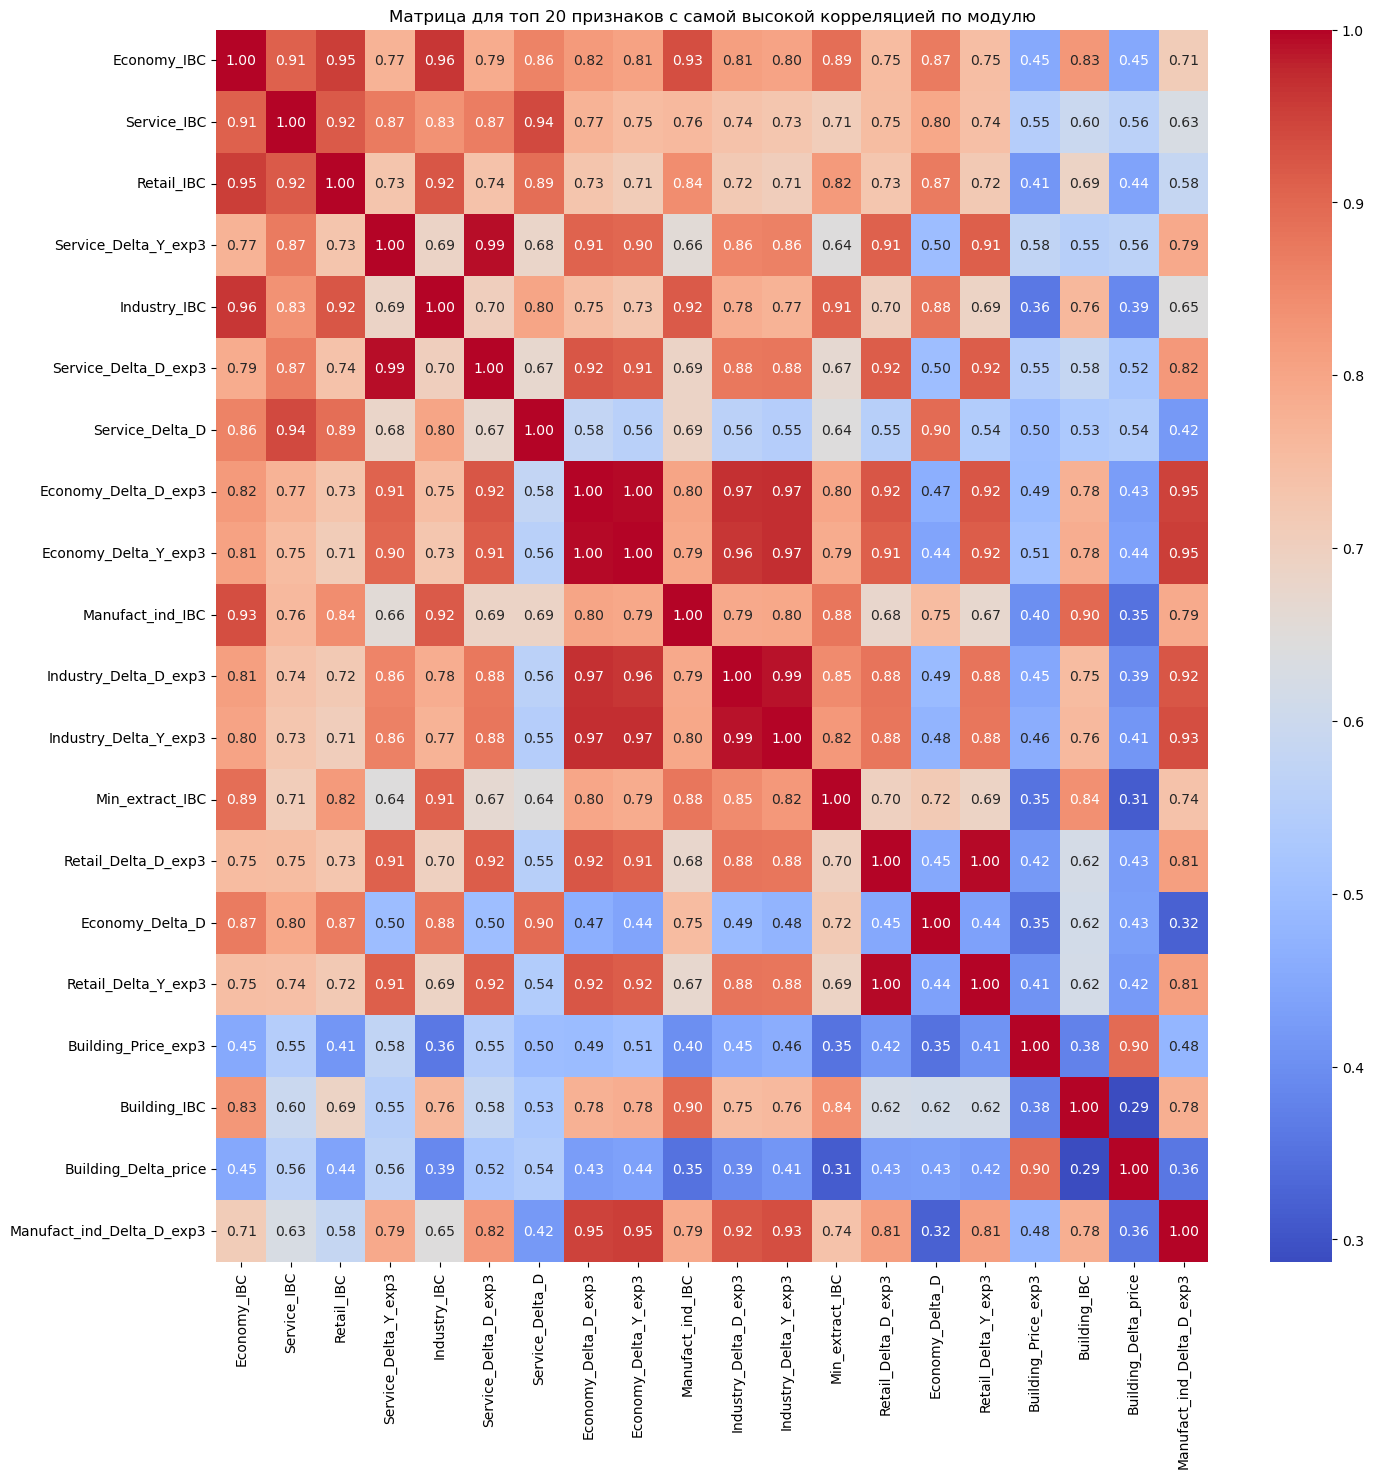

In [66]:
corr = data_merged.corr()

top_features = corr.abs().sum().sort_values(ascending=False).head(20).index
top_corr = corr.loc[top_features, top_features]

plt.figure(figsize=(16, 16))
plt.title('Матрица для топ 20 признаков с самой высокой корреляцией по модулю')
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

<h3>Feature engineering</h3>

In [67]:
def create_date_features(df, date_col='Date'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['week_of_year'] = df[date_col].dt.isocalendar().week
    df['quarter'] = df[date_col].dt.quarter
    
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    
    return df.drop(columns=[date_col])

data_merged_engineered = create_date_features(data_merged)

In [68]:
target_columns = [col for col in data_merged_engineered.columns if col.split('_')[-1] == 'IBC']
features = data_merged_engineered.drop(columns=target_columns)
targets = data_merged_engineered[target_columns]

In [69]:
test_size = 0.2  

split_idx = int(len(data) * (1 - test_size))

X_train, X_test = features[:split_idx], features[split_idx:]
y_train, y_test = targets[:split_idx], targets[split_idx:]

<h3>Масштабирование признаков</h3>

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>Обучение xgb</h3>

In [71]:
multi_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mae'
    )
)

multi_model.fit(X_train_scaled, y_train)

y_pred = multi_model.predict(X_test_scaled)

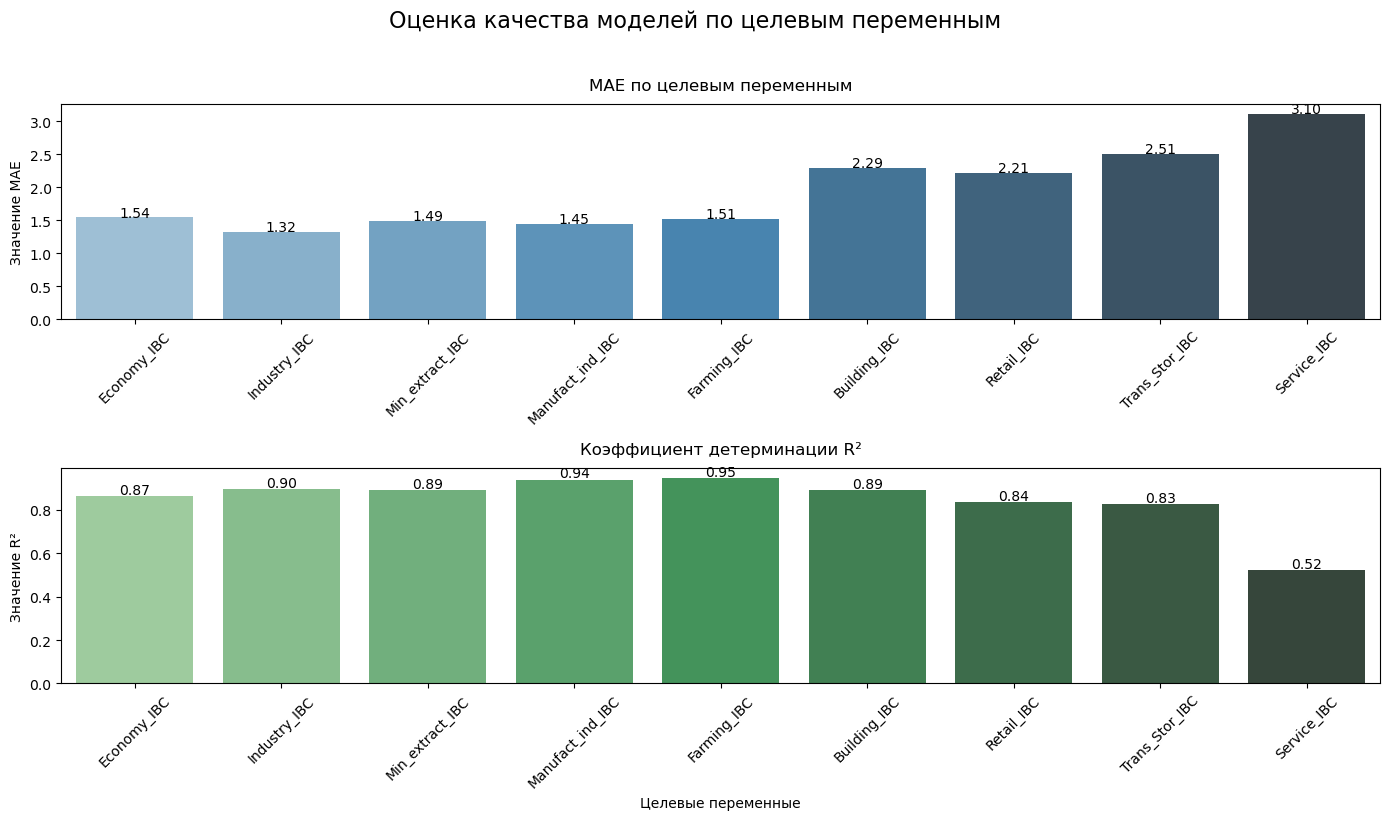

In [72]:
metrics = []
for i, col in enumerate(target_columns):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    metrics.append({
        'Target': col,
        'MAE': mae,
        'R²': r2
    })
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(14, 8))
plt.suptitle('Оценка качества моделей по целевым переменным', y=1.02, fontsize=16)

plt.subplot(2, 1, 1)
sns.barplot(data=metrics_df, x='Target', y='MAE', palette='Blues_d')
plt.title('MAE по целевым переменным', pad=10)
plt.xlabel('')
plt.ylabel('Значение MAE')
plt.xticks(rotation=45)
for i, v in enumerate(metrics_df['MAE']):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')

plt.subplot(2, 1, 2)
sns.barplot(data=metrics_df, x='Target', y='R²', palette='Greens_d')
plt.title('Коэффициент детерминации R²', pad=10)
plt.xlabel('Целевые переменные')
plt.ylabel('Значение R²')
plt.xticks(rotation=45)
for i, v in enumerate(metrics_df['R²']):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

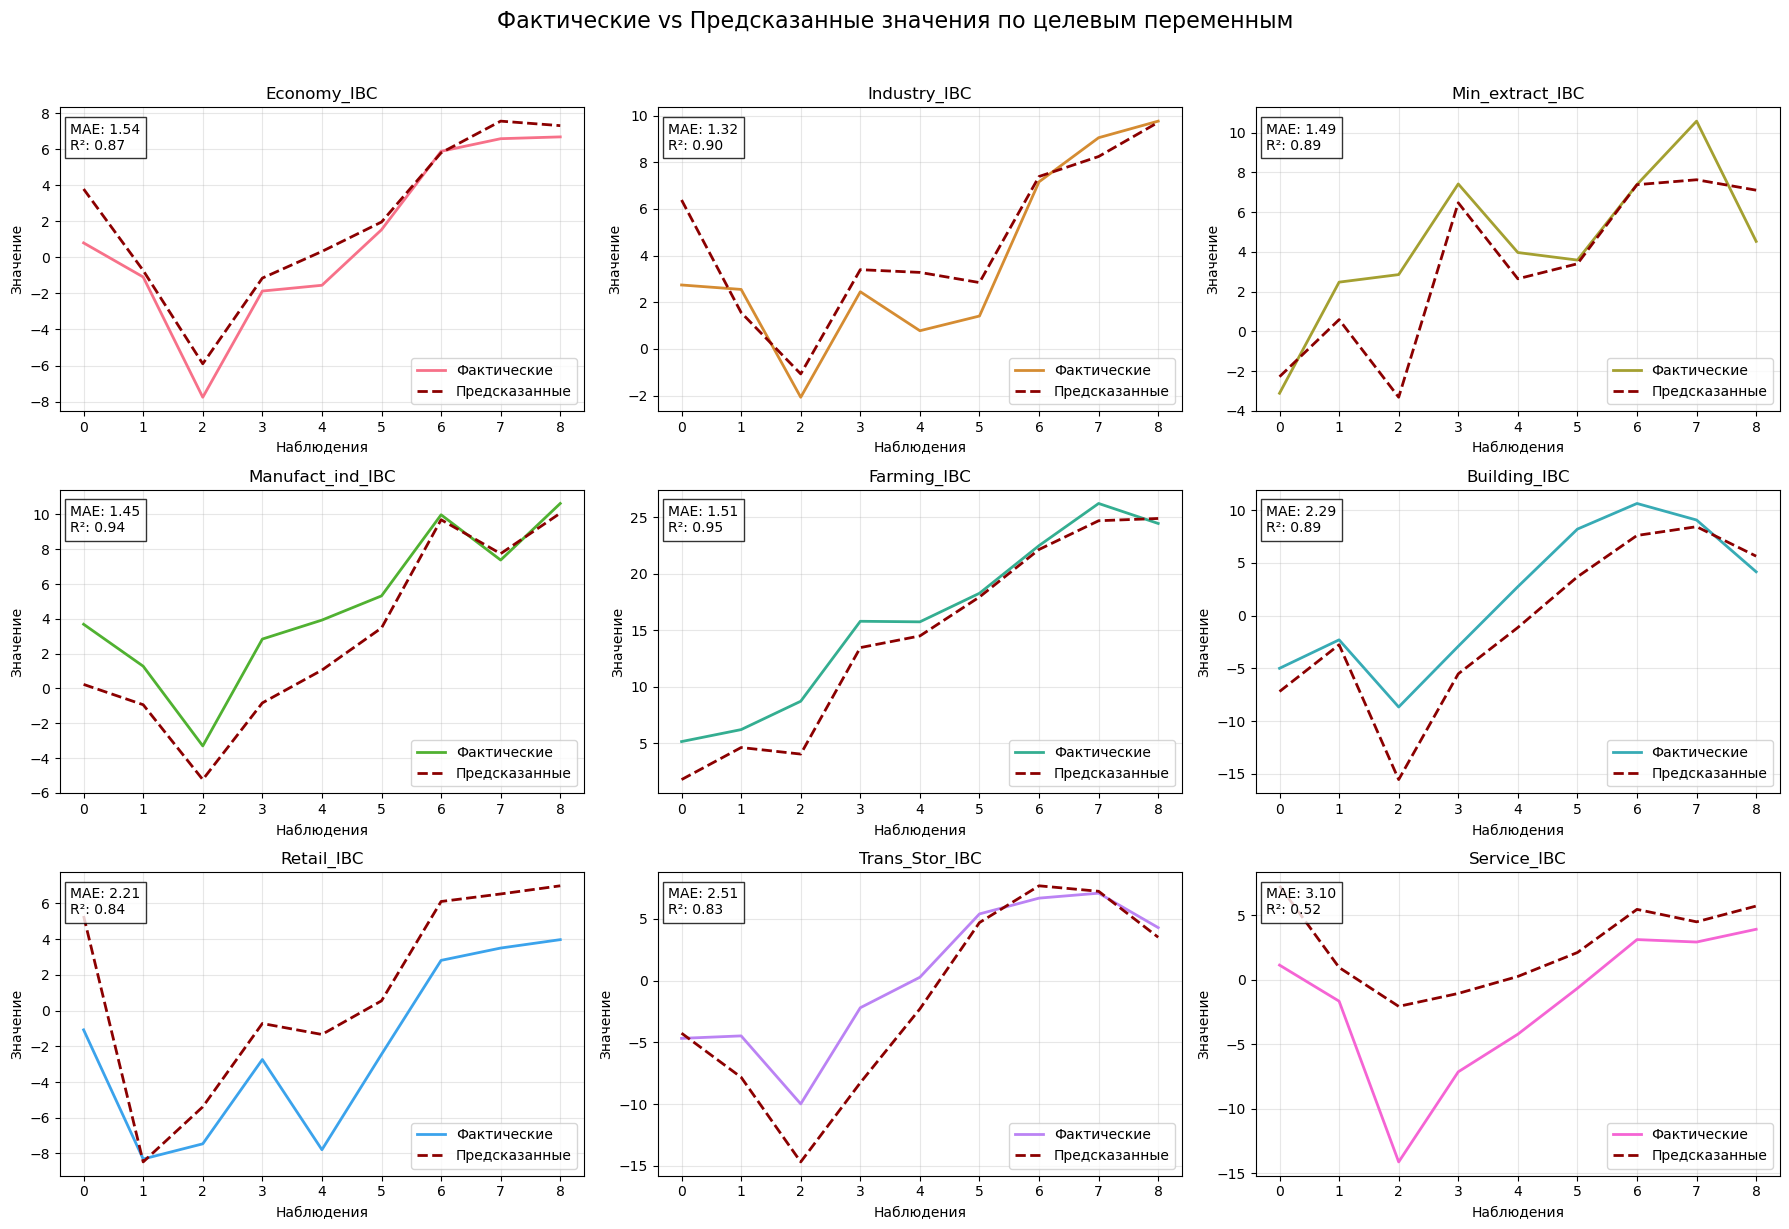

In [73]:
n_targets = y_test.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_targets / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
fig.suptitle('Фактические vs Предсказанные значения по целевым переменным', y=1.02, fontsize=16)

if n_targets == 1:
    axes = np.array([axes])
axes = axes.flatten()

palette = sns.color_palette("husl", n_targets)

for i, (ax, target_col) in enumerate(zip(axes, target_columns)):
    n_show = min(100, y_test.shape[1])
    x_axis = np.arange(n_show)
    
    ax.plot(x_axis, y_test.iloc[-n_show:, i], 
            label='Фактические', color=palette[i], linewidth=2)
    
    ax.plot(x_axis, y_pred[-n_show:, i], 
            label='Предсказанные', linestyle='--', color='darkred', linewidth=2)

    ax.set_title(target_col, fontsize=12)
    ax.set_xlabel('Наблюдения')
    ax.set_ylabel('Значение')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    rmse = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    ax.text(0.02, 0.95, f"MAE: {rmse:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=10, verticalalignment='top')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<h3>LIME Interpretation</h3>


=== Интерпретация для целевой переменной: Economy_IBC ===
Intercept 7.2612053523488695
Prediction_local [6.13207252]
Right: 5.2244153


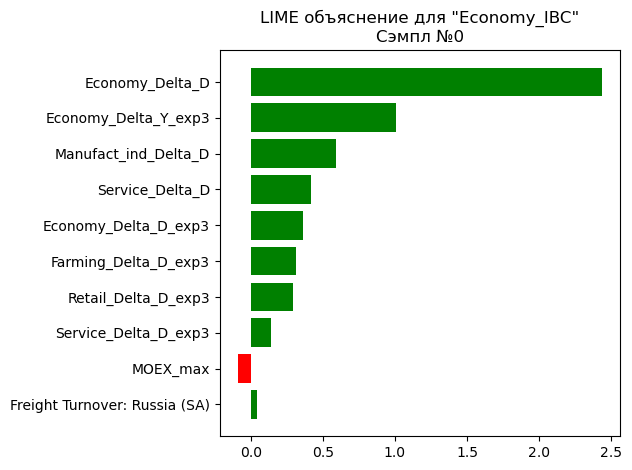


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4355
Economy_Delta_Y_exp3: 1.0041
Manufact_ind_Delta_D: 0.5878
Service_Delta_D: 0.4144
Economy_Delta_D_exp3: 0.3627
Farming_Delta_D_exp3: 0.3137
Retail_Delta_D_exp3: 0.2933
Service_Delta_D_exp3: 0.1359
MOEX_max: -0.0904
Freight Turnover: Russia (SA): 0.0421

=== Интерпретация для целевой переменной: Industry_IBC ===
Intercept 7.289823041134231
Prediction_local [5.97240142]
Right: 5.2244153


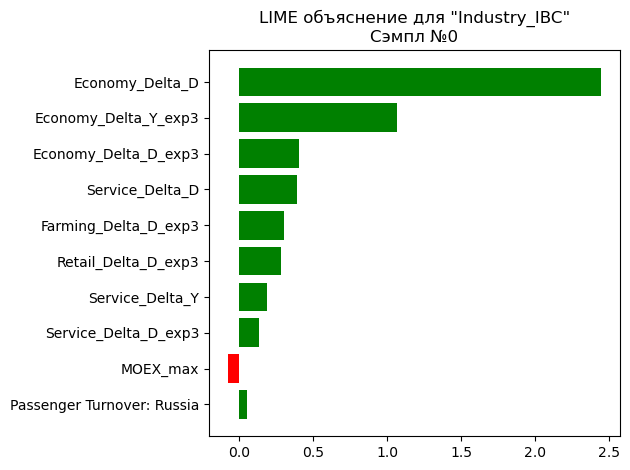


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4490
Economy_Delta_Y_exp3: 1.0661
Economy_Delta_D_exp3: 0.4008
Service_Delta_D: 0.3895
Farming_Delta_D_exp3: 0.2989
Retail_Delta_D_exp3: 0.2830
Service_Delta_Y: 0.1886
Service_Delta_D_exp3: 0.1339
MOEX_max: -0.0789
Passenger Turnover: Russia: 0.0507

=== Интерпретация для целевой переменной: Min_extract_IBC ===
Intercept 7.258362558572636
Prediction_local [6.00812332]
Right: 5.2244153


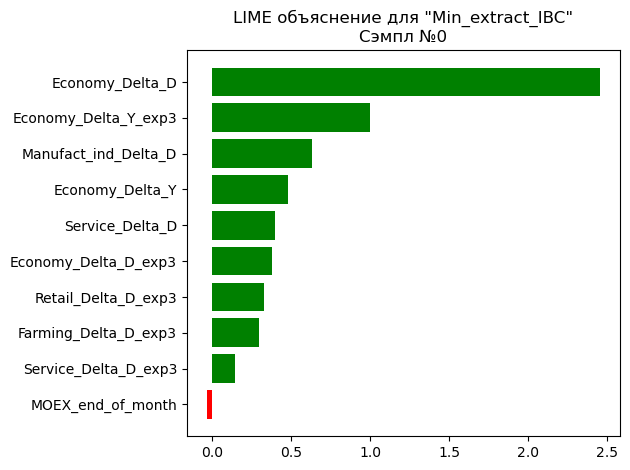


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4572
Economy_Delta_Y_exp3: 0.9990
Manufact_ind_Delta_D: 0.6314
Economy_Delta_Y: 0.4766
Service_Delta_D: 0.3971
Economy_Delta_D_exp3: 0.3781
Retail_Delta_D_exp3: 0.3265
Farming_Delta_D_exp3: 0.2950
Service_Delta_D_exp3: 0.1406
MOEX_end_of_month: -0.0377

=== Интерпретация для целевой переменной: Manufact_ind_IBC ===
Intercept 7.226901656089084
Prediction_local [6.00702805]
Right: 5.2244153


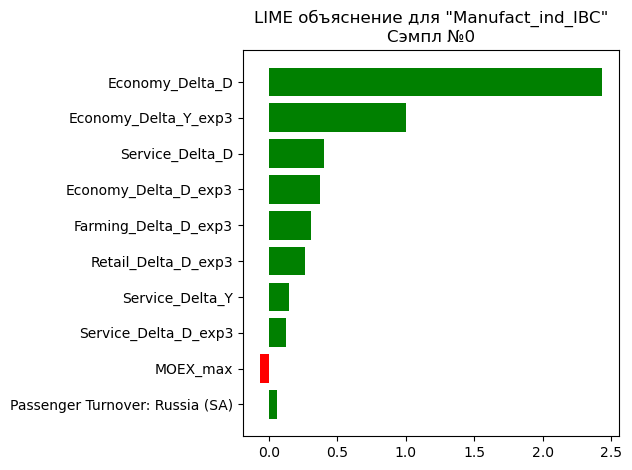


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4332
Economy_Delta_Y_exp3: 1.0044
Service_Delta_D: 0.4022
Economy_Delta_D_exp3: 0.3766
Farming_Delta_D_exp3: 0.3065
Retail_Delta_D_exp3: 0.2672
Service_Delta_Y: 0.1471
Service_Delta_D_exp3: 0.1273
MOEX_max: -0.0642
Passenger Turnover: Russia (SA): 0.0595

=== Интерпретация для целевой переменной: Farming_IBC ===
Intercept 7.237602345926031
Prediction_local [6.02202519]
Right: 5.2244153


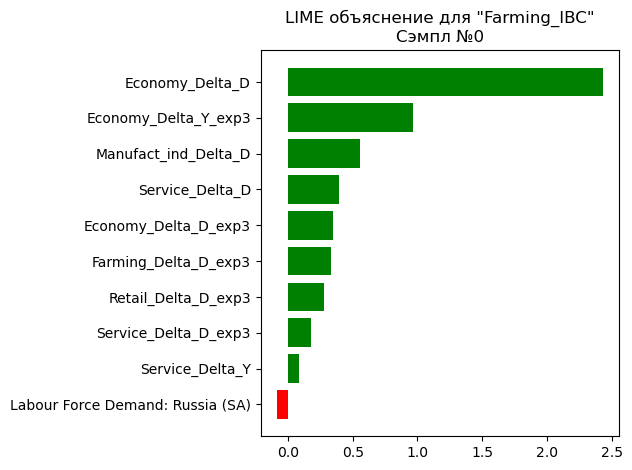


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4321
Economy_Delta_Y_exp3: 0.9682
Manufact_ind_Delta_D: 0.5599
Service_Delta_D: 0.3914
Economy_Delta_D_exp3: 0.3486
Farming_Delta_D_exp3: 0.3304
Retail_Delta_D_exp3: 0.2805
Service_Delta_D_exp3: 0.1819
Service_Delta_Y: 0.0873
Labour Force Demand: Russia (SA): -0.0842

=== Интерпретация для целевой переменной: Building_IBC ===
Intercept 7.253564649373644
Prediction_local [5.88386263]
Right: 5.2244153


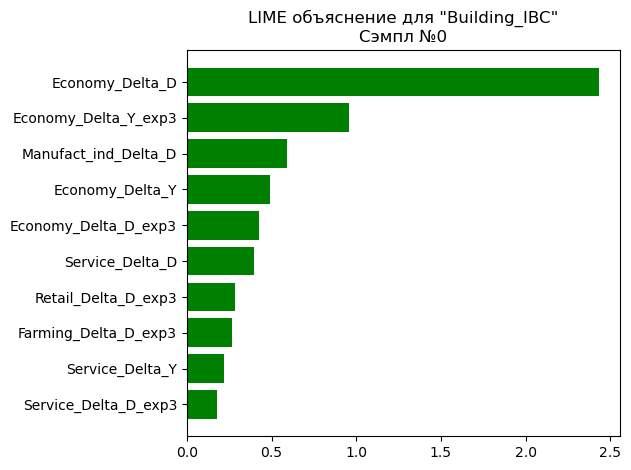


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4352
Economy_Delta_Y_exp3: 0.9545
Manufact_ind_Delta_D: 0.5907
Economy_Delta_Y: 0.4912
Economy_Delta_D_exp3: 0.4243
Service_Delta_D: 0.3957
Retail_Delta_D_exp3: 0.2829
Farming_Delta_D_exp3: 0.2681
Service_Delta_Y: 0.2168
Service_Delta_D_exp3: 0.1772

=== Интерпретация для целевой переменной: Retail_IBC ===
Intercept 7.218710581783372
Prediction_local [5.94250935]
Right: 5.2244153


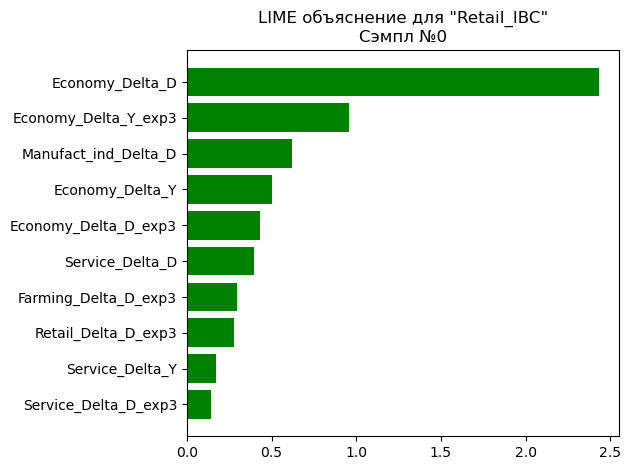


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4318
Economy_Delta_Y_exp3: 0.9548
Manufact_ind_Delta_D: 0.6189
Economy_Delta_Y: 0.5019
Economy_Delta_D_exp3: 0.4292
Service_Delta_D: 0.3965
Farming_Delta_D_exp3: 0.2979
Retail_Delta_D_exp3: 0.2781
Service_Delta_Y: 0.1693
Service_Delta_D_exp3: 0.1420

=== Интерпретация для целевой переменной: Trans_Stor_IBC ===
Intercept 7.280556134199333
Prediction_local [6.17260831]
Right: 5.2244153


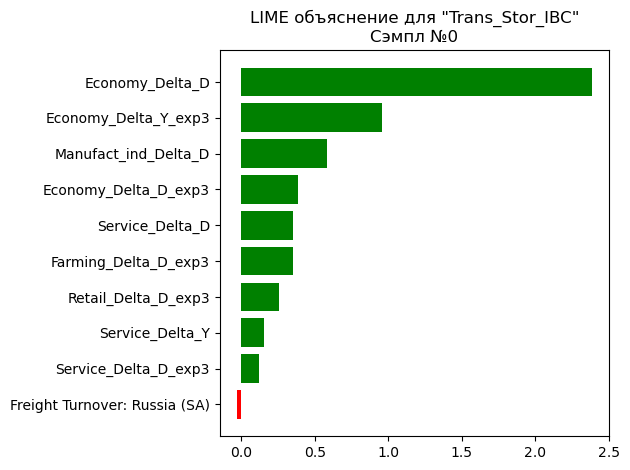


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.3817
Economy_Delta_Y_exp3: 0.9579
Manufact_ind_Delta_D: 0.5858
Economy_Delta_D_exp3: 0.3874
Service_Delta_D: 0.3555
Farming_Delta_D_exp3: 0.3498
Retail_Delta_D_exp3: 0.2556
Service_Delta_Y: 0.1543
Service_Delta_D_exp3: 0.1240
Freight Turnover: Russia (SA): -0.0255

=== Интерпретация для целевой переменной: Service_IBC ===
Intercept 7.246462500595965
Prediction_local [6.05087378]
Right: 5.2244153


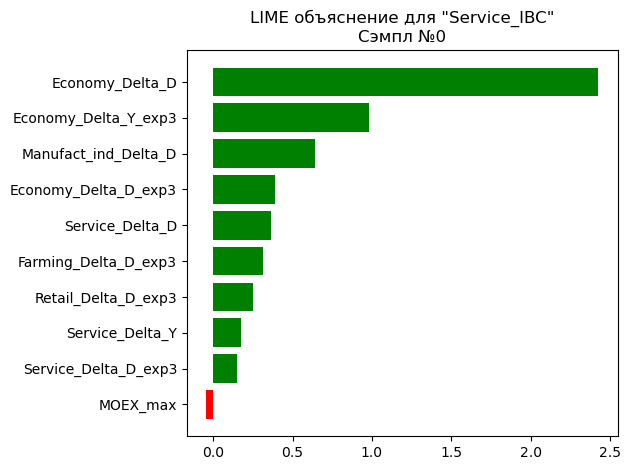


Информация о сэмпле №0:
                             0
Economy_Delta_Y      -0.178901
Economy_Delta_Y_exp3 -0.313684
Economy_Delta_D      -0.136759
Economy_Delta_D_exp3 -0.402755
Economy_Price_exp3   -1.215132
...                        ...
quarter               0.474492
month_sin            -0.734024
month_cos            -1.217633
day_of_week_sin      -1.115175
day_of_week_cos       0.882155

[97 rows x 1 columns]

Важность признаков:
Economy_Delta_D: 2.4236
Economy_Delta_Y_exp3: 0.9795
Manufact_ind_Delta_D: 0.6446
Economy_Delta_D_exp3: 0.3899
Service_Delta_D: 0.3616
Farming_Delta_D_exp3: 0.3153
Retail_Delta_D_exp3: 0.2489
Service_Delta_Y: 0.1761
Service_Delta_D_exp3: 0.1495
MOEX_max: -0.0423


In [74]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=target_columns,
    mode='regression',
    verbose=True,
    discretize_continuous=False
)

sample_idx = 0  
instance = X_test_scaled[sample_idx]

def model_predict(x):
    return multi_model.predict(x)

for target_idx, target_name in enumerate(target_columns):
    print(f"\n=== Интерпретация для целевой переменной: {target_name} ===")
    
    exp = explainer_lime.explain_instance(
        data_row=instance,
        predict_fn=model_predict,
        num_features=10,
        top_labels=1
    )
    
    fig = exp.as_pyplot_figure(label=target_idx)
    plt.title(f'LIME объяснение для "{target_name}"\nСэмпл №{sample_idx}')
    plt.tight_layout()
    plt.show()
    
    print(f"\nИнформация о сэмпле №{sample_idx}:")
    print(pd.DataFrame([instance], columns=X_train.columns).T)
    
    print("\nВажность признаков:")
    for feature, weight in exp.as_list(label=target_idx):
        print(f"{feature}: {weight:.4f}")

<h2>SHAP Interpretation</h2>

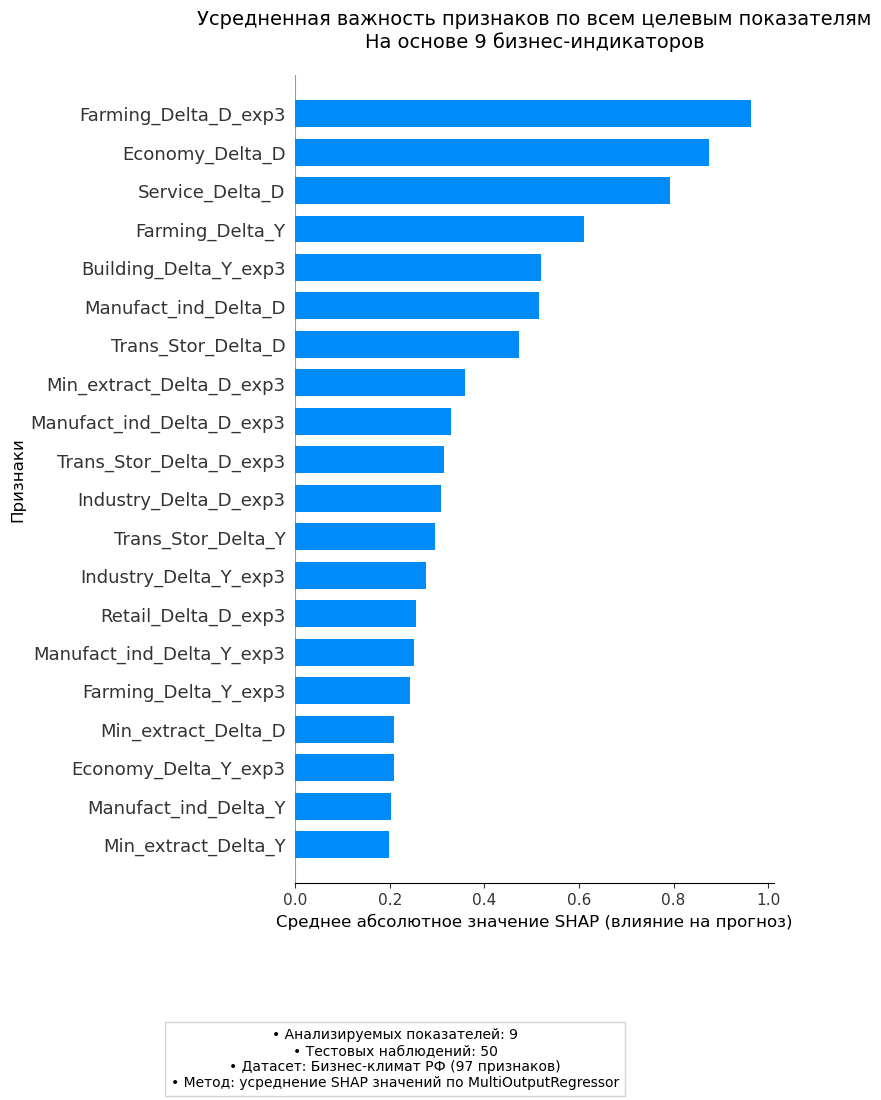



Распределение влияния признаков:


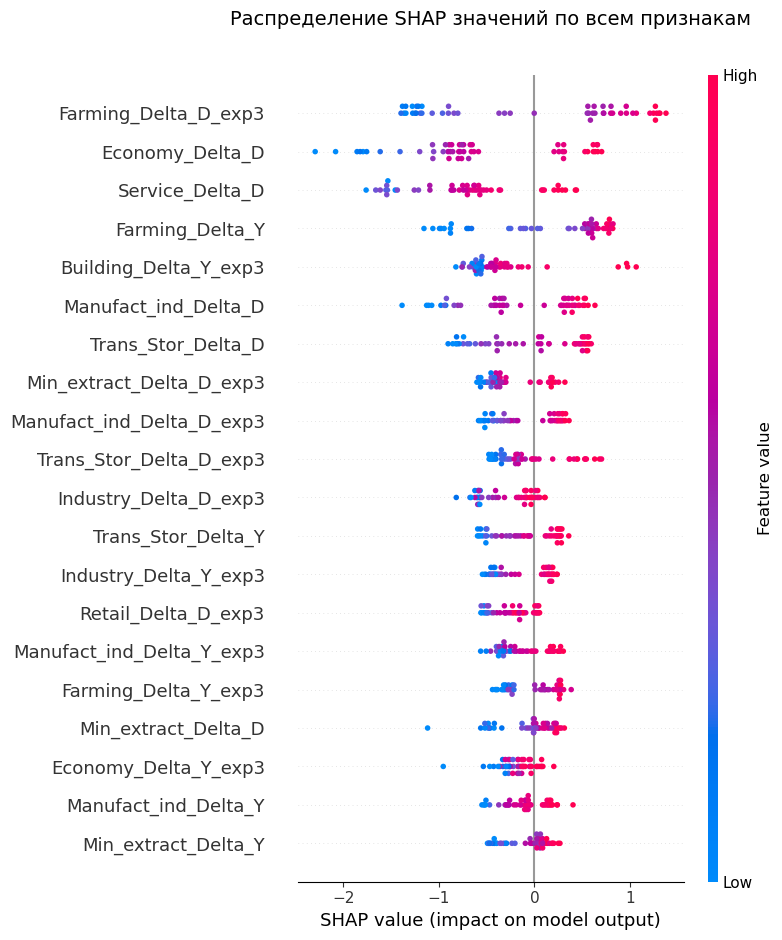


Топ-5 наиболее влиятельных признаков:
1. Farming_Delta_D_exp3: 0.9639
2. Economy_Delta_D: 0.8760
3. Service_Delta_D: 0.7921
4. Farming_Delta_Y: 0.6107
5. Building_Delta_Y_exp3: 0.5192


In [75]:

all_shap_values = []
for estimator in multi_model.estimators_:
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X_test_scaled)
    all_shap_values.append(shap_values)

mean_shap_values = np.mean(all_shap_values, axis=0)

plt.figure(figsize=(12, 8))

shap.summary_plot(
    mean_shap_values,
    X_test_scaled,
    feature_names=X_train.columns,
    plot_type="bar",
    show=False
)

plt.title('Усредненная важность признаков по всем целевым показателям\n'
         f'На основе {len(target_columns)} бизнес-индикаторов', 
         pad=20, fontsize=14)
plt.xlabel('Среднее абсолютное значение SHAP (влияние на прогноз)', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

textstr = '\n'.join([
    f'• Анализируемых показателей: {len(target_columns)}',
    f'• Тестовых наблюдений: {X_test_scaled.shape[0]}',
    f'• Датасет: Бизнес-климат РФ ({X_train.shape[1]} признаков)',
    '• Метод: усреднение SHAP значений по MultiOutputRegressor'
])
plt.gcf().text(0.5, -0.15, textstr, ha='center', fontsize=10, bbox=dict(facecolor='none', edgecolor='lightgray'))

plt.tight_layout()
plt.show()

print("\n\nРаспределение влияния признаков:")
shap.summary_plot(
    mean_shap_values,
    X_test_scaled,
    feature_names=X_train.columns,
    plot_type="dot",
    show=False
)
plt.title('Распределение SHAP значений по всем признакам\n', 
         pad=20, fontsize=14)
plt.tight_layout()
plt.show()

mean_abs_shap = np.mean(np.abs(mean_shap_values), axis=0)
top_features_idx = np.argsort(mean_abs_shap)[-5:][::-1]
top_features = X_train.columns[top_features_idx]

print("\nТоп-5 наиболее влиятельных признаков:")
for i, feat in enumerate(top_features, 1):
    print(f"{i}. {feat}: {mean_abs_shap[top_features_idx[i-1]]:.4f}")